# Time evolution of the Joint distribution $P(m, p; t)$

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import dill
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages # to save multipage pdf

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
---

# Dynamics of gene expression.

So far we have determined how to compute the dynamics of the distribution moments $\ee{m^xp^y}(t)$. We also developed a MaxEnt approach to approximate the distribution $P(m, p)$ based on these moments. In this notebook we will combine both approaches to generate a numerical approximation of the time evolution of the distribution $P(m, p; t)$.

## Dynamics of induction

As a first exercise we will compute the dynamics of a strain after being induced. For this we will assume that the cells were at steady state when the inducer concentration $c$ was zero. At time $t_o$ the media was spiked with an inducer concentration $c = c_o$ (which we will take as saturated concentrations of inducer) and we will track over time how does the joint distribution $P(m, p; t)$ evolve.

### Finding the initial conditions
To compute these dynamics we first need to find the inital conditions of the system. These will be the steady-state values of the uninduced distribution. We will do this using the `dpdt` function that we generated to compute time evolution of the moments rather than our analytical results for the steady state expression because the initial conditions for our numerical integration of the moment equations require not the global moments, i.e. the sum of the moments on each promoter state, but the individual contributions of each promoter state. In other words we do not need to know $\ee{\bb{m}(t_o)}$ but the three components of this moment $\left[ \ee{m_P(t_o)}, \ee{m_E(t_o)}, \ee{m_R(t_o)} \right]$.

For this we need to define the parameters for the regulated promoter.
We will specifically focus on the **O2 R260** strain as our example.

In [2]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)

# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']

# Add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['rep'] = 260 # repressors / cell
par['eRA'] = -13.9  # kBT

print(par)

{'kp_on': 5.5, 'kp_off': 28.9, 'rm': 87.6, 'gm': 1, 'Nns': 4600000.0, 'ka': 139, 'ki': 0.53, 'epsilon': 4.5, 'k0': 0.9507042253521127, 'gp': 0.09753521126760563, 'rp': 97.53521126760563, 'rep': 260, 'eRA': -13.9}


Now let's define the matrices necessary for computing the time dynamics of the moments.

In [3]:
# Define initial concentration
c0 = 0

# Extract parameters from dictionary
kp_on = par['kp_on']
kp_off = par['kp_off']
rm = par['rm']
gm = par['gm']
rp = par['rp']
gp = par['gp']
ka = par['ka']
ki = par['ki']
epsilon = par['epsilon']
Nns = par['Nns']
rep = par['rep']
eRA = par['eRA']

# Calculate the repressor on rate including the MWC model
kr_on = k0_norm * rep * chann_cap.p_act(c0, ka, ki, epsilon) 
kr_off = chann_cap.kr_off_fun(eRA, k0_norm, kp_on, kp_off, Nns)

In [4]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

# Define the state transition matrix
Km_reg = np.array([[-kp_off, kp_on, 0], 
                   [kp_off, -(kp_on + kr_on), kr_off],
                   [0, kr_on, -kr_off]])

Now we will run the numerical integration for a long time and keep the last time point as the initial conditions for our induction simulation.

In [5]:
# Define time on which to perform integration
t = np.linspace(0, 100, 300)

# Define initial conditions
m0_init = [0.3, 0.3, 0.4]
m1_init = [0, 0, 0]
m2_init = [0, 0, 0]
m3_init = [0, 0, 0]
p1_init = [0, 0, 0]
mp_init = [0, 0, 0]
p2_init = [0, 0, 0]
m2p_init = [0, 0, 0]
mp2_init = [0, 0, 0]
p3_init = [0, 0, 0]

# Integrate dynamics
sol = sp.integrate.odeint(chann_cap.dpdt, 
                          m0_init + m1_init + m2_init + m3_init +\
                          p1_init + mp_init + p2_init + m2p_init +\
                          mp2_init + p3_init,
                          t,
                          args=(Km_reg, Rm_reg, Gm_reg,
                                Rp_reg, Gp_reg))

# keep last point as initial conditions
sim_init = sol[-1, :]

# Print global moments.
sim_init.reshape(-1, 3).sum(axis=1)

array([  1.00000000e+00,   3.72059765e-01,   1.61381193e+00,
         1.16813282e+01,   3.72041674e+02,   2.72982681e+02,
         2.73347992e+05,   1.00291335e+03,   2.51522107e+05,
         2.52064484e+08])

### Integrating dynamics after induction.

Now that we have the initial conditions for our induction simulation, let's compute the dynamics assuming that we spark a high concentration of inducer into the media.

The only parameters that need to be updated are the repressor rates $\kron$ and $\kroff$ given the inducer concentration.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 65, 65)

# Define concentration after induction
c1 = 5000 # µM IPTG
# Calculate the repressor on rate including the MWC model
kr_on = k0_norm * rep * chann_cap.p_act(c1, ka, ki, epsilon) 
kr_off = chann_cap.kr_off_fun(eRA, k0_norm, kp_on, kp_off, Nns)

# Update the state transition matrix
Km_reg = np.array([[-kp_off, kp_on, 0], 
                   [kp_off, -(kp_on + kr_on), kr_off],
                   [0, kr_on, -kr_off]])

# Integrate dynamics with new initial conditions
sol = sp.integrate.odeint(chann_cap.dpdt, sim_init, t,
                          args=(Km_reg, Rm_reg, Gm_reg,
                                Rp_reg, Gp_reg))

# Convert solution to tidy DataFrame
df = chann_cap.dynamics_to_df(sol, t)
df.head()

,time,m1,m2,m3,p1,mp,p2,m2p,mp2,p3
0,0.000000,0.372060,1.613812,11.681328,372.041674,272.982681,2.733480e+05,1002.913348,2.515221e+05,2.520645e+08
1,1.015625,7.511380,88.377633,1319.262783,698.002393,6582.521479,7.026157e+05,61247.393844,6.212033e+06,7.711418e+08
2,2.031250,11.216121,165.826809,2954.373425,1546.991505,20109.258336,2.955717e+06,223693.272272,3.439819e+07,5.353689e+09
3,3.046875,12.560815,199.702637,3761.569264,2533.885774,35267.913015,7.450811e+06,394029.253792,9.098221e+07,1.990341e+10
4,4.062500,13.047838,212.734869,4085.048900,3506.694714,49476.608958,1.379167e+07,538602.363618,1.700002e+08,4.845026e+10


For comparison let's compute the global steady-state moments with the analytical expressions using these parameters.

In [7]:
# List the functions
moment_fun = [chann_cap.first_reg_m,
              chann_cap.second_reg_m,
              chann_cap.third_reg_m,
              chann_cap.first_reg_p,
              chann_cap.second_reg_p,
              chann_cap.third_reg_p]

# Define names of dataframe index
names = ['m1', 'm2', 'm3', 'p1', 'p2', 'p3']

ss_moments = chann_cap.moment_ss_reg(moment_fun, c1, **par)
df_ss = pd.Series(ss_moments, index=names)
df_ss

m1    1.332439e+01
m2    2.203156e+02
m3    4.276364e+03
p1    1.332439e+04
p2    1.814533e+08
p3    2.305165e+12
dtype: float64

Let's look at the moment dynamics.

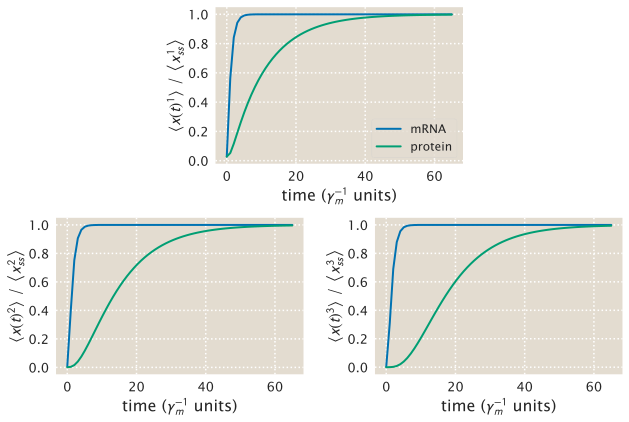

In [8]:
# Initialize figure
fig = plt.figure(figsize=(9, 6))

# Define axis to have two on the bottom and one on the top
ax = list()
ax.append(plt.subplot2grid((2, 4), (0, 1), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 0), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 2), colspan=2, rowspan=1))

# Define array with names of moments to plot
moments_m = ['m1', 'm2', 'm3']
moments_p = ['p1', 'p2', 'p3']

# Loop through groups
for i in range(len(moments_m)):
    # Plot moments moment
    ax[i].plot(df['time'], df[moments_m[i]] / df_ss[moments_m[i]],
              label='mRNA')
    ax[i].plot(df['time'], df[moments_p[i]] / df_ss[moments_p[i]],
              label='protein')
    
    # Label axis
    ax[i].set_xlabel('time ($\gamma_m^{-1}$ units)')
    ax[i].set_ylabel(r'$\left\langle x(t)^{:d} \right\rangle$ / '.format(i+1) +\
                     r'$\left\langle x_{{ss}}^{:d} \right\rangle$'.format(i+1))
    
# Include legend
ax[0].legend(fontsize=12)

plt.tight_layout()

Everything seems to be working adequately since the dynamics are converging to the predicted steady-state value in a coherent time scale. Time to compute the distribution dynamics using the MaxEnt approach.

# Fitting the MaxEnt distribution for each time point.

We now have the dynamics of the distribution moments in hand. With this we can find the value of the Lagrange multipliers associated with the MaxEnt approximation.

Let's first define the mRNA and protein sample space and compute the features required by the `maxentropy` package in order to fit the distribution.

In [9]:
# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.arange(0, 2.3E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# List all functions used to compute the products associated with each of
# the constraints
feature_fun = [chann_cap.m1_fn, chann_cap.m2_fn, chann_cap.m3_fn,
               chann_cap.p1_fn, chann_cap.p2_fn, chann_cap.mp_fn]

# Initialize matrix to save all the features that are fed to the 
# maxentropy function
features = np.zeros([len(feature_fun), len(samplespace)])

# Loop through constraints and compute features
for i, feat in enumerate(feature_fun):
    features[i, :] = [feat(x) for x in samplespace]

Now let's loop through each of the time points, fitting the MaxEnt distribution each time.

In [38]:
# Initialize data frame to save the lagrange multipliers.
names = ['time', 'lambda_m1', 'lambda_m2', 'lambda_m3',
         'lambda_p1', 'lambda_p2', 'lambda_mp']
df_maxEnt = pd.DataFrame([], columns=names)

# Extract time from the moment dynamics
time = df['time'].values
# Define column names containing the constraints used to fit the distribution
constraints_names = ['m1', 'm2', 'm3', 'p1', 'p2', 'mp']


fit_dist = False
if fit_dist:
    # Define the minimum entropy 
    model = MinDivergenceModel(features, samplespace)
    model.algorithm = 'Powell'
    model.tol = 5E-5
    model.paramstol = 5E-5
    model.maxiter = 1000
    model.callingback = True
    
    # Loop through time points
    for i, t in enumerate(time):
        print('time-point: ', i)
        # Extract constraints
        constraints = df.loc[i][constraints_names].values
        # Change the dimensionality of the array
        X = np.reshape(constraints, (1, -1))
        # Fit the model
        model.fit(X)
        # Save Lagrange multipliers into dataframe
        series = pd.Series(np.append(t, model.params), index=names)
        df_maxEnt = df_maxEnt.append(series, ignore_index=True)
        # Save partial progress
        df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_dynamics.csv')
        
    # Append the extra information about the dynamics
    df_maxEnt['operator'] = ['O2'] * len(time)
    df_maxEnt['binding_energy'] = np.repeat(par['eRA'], len(time))
    df_maxEnt['repressors'] = np.repeat(par['rep'], len(time))
    # Save final version of DataFrame
    df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_dynamics.csv')

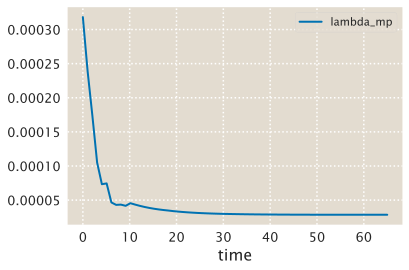

In [37]:
df_maxEnt.plot('time', 'lambda_mp')

Now that we have all of the Lagrange multipliers we can compute whichever probability we want. Let's define a vectorized function that returns the 2D probability distribution given an mRNA and protein sample space along with a list of Lagrange Multipliers.

In [87]:
def maxEnt_from_lagrange(mRNA, protein, lagrange, 
                         exponents=[(1, 0), (2, 0), (3, 0), 
                                   (0, 1), (0, 2), (1, 1)], log=False):
    '''
    Computes the mRNA and protein joint distribution P(m, p) as approximated
    by the MaxEnt methodology given a set of Lagrange multipliers.
    Parameters
    ----------
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
    log : bool. Default = False
        Boolean indicating if the log probability should be returned.
    Returns
    -------
    Pmp : 2D-array. len(mRNA) x len(protein)
        2D MaxEnt distribution.
    '''
    # Generate grid of points
    mm, pp = np.meshgrid(mRNA, protein)
    
    # Initialize 3D array to save operations associated with each lagrange
    # multiplier
    operations = np.zeros([len(lagrange), len(protein), len(mRNA)])
    
    # Compute operations associated with each Lagrange Multiplier
    for i, expo in enumerate(exponents):
        operations[i, :, :] = lagrange[i] * mm**expo[0] * pp**expo[1]
    
    # check if the log probability should be returned
    if log:
        return np.sum(operations, axis=0)
    else:
        return np.exp(np.sum(operations, axis=0))

Let's now import the DataFrame witht the lagrange multipliers.

In [90]:
# Read the dataframe with the lagrange multipliers
df_maxEnt = pd.read_csv(datadir + 'O2_R260_lagrange_dynamics.csv', index_col=0)
df_maxEnt.head(3)

,time,lambda_m1,lambda_m2,lambda_m3,lambda_p1,lambda_p2,lambda_mp,operator,binding_energy,repressors
0,0.000000,-2.338170,0.290235,-0.013962,-0.002374,-3.675919e-07,0.000318,O2,-13.9,260
1,1.015625,-0.020503,-0.014962,0.000068,0.000436,-2.066258e-06,0.000239,O2,-13.9,260
2,2.031250,0.094035,-0.018907,0.000088,0.001583,-1.173959e-06,0.000174,O2,-13.9,260


Now let's generate an animated gif of the evolution of the distribution.

In [97]:
def joint_animated_gif(df, mRNA, protein, figname, delay=25, outdir=figdir):
    '''
    Generates an animated gif using ImageMagick for the different 
    distributions.
    '''
    # Loop through distributions
    for i, row in df.iterrows():
        # Determine title
        title = 'O2 - R260; time: {:.1f}'.format(row['time'])
        # Extract lagrange multipliers
        columns = [x for x in df_maxEnt.columns if 'lambda' in x]
        lagrange = row[columns].values
        Pmp = maxEnt_from_lagrange(mRNA_space, protein_space, lagrange)
        # Generate temporary png images
        fig = chann_cap.joint_marginal_plot(mRNA_space, protein_space, Pmp, 
                              xlabel='mRNA / cell', ylabel='protein / cell',
                              title=title)
        plt.savefig(outdir + 'tmp-{:02d}.png'.format(i),
                   bbox_inches='tight')
        plt.close()
    # Run ImageMagick to convert to png
    command = 'convert -layers OptimizePlus -delay {0:d} ' +\
              '{1:s}tmp-??.png '+\
              '-loop 0 {1:s}{2:s}.gif'
    os.system(command.format(delay, outdir, figname))
    # Remove temporary pngs
    os.system('rm {:s}tmp-*png'.format(outdir))

In [98]:
joint_animated_gif(df_maxEnt, mRNA_space, protein_space,
                   'O2_R260_dynamics', 50)